# Notebook de test des données lapi post-traitees

In [26]:
%load_ext autoreload
%autoreload 
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import Connexion_Transfert as ct
import donnees_posttraitees as t
import graphs as g
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
import os, math
from sklearn.cluster import DBSCAN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. import des données, traitement de mise en forme
## 1.1 Import
Les données sont importées sur la période du 24/01/19 au 23/02/19, sur laquelle il n'y a pas de manque de données à priori

In [29]:
%time df_passages, df_plaques, df_immat=t.ouvrir_fichier_lapi_final('2019-01-28 00:00:00','2019-02-01 23:59:59')

## 1.2. Suppression des doublons

In [30]:
%time df_passages=t.supprimer_doublons(df_passages)

Wall time: 15.4 s


## 1.3 Ajout de l'attribut de différenciation VL / PL

In [31]:
%time df_passages2=t.affecter_type(df_passages,df_immat)

Wall time: 1min 50s


***ATTENTION : ENCORE 18764 IMMATRCULATION COURTE PRESENTES DANS TE_PASSAGES ET NON PRENSENTES DANS TE_PLAQUES_COURTE :***

In [69]:
df_passages2.loc[df_passages2.immatriculation.isna()].merge(df_plaques, left_on='immat', right_on='chiffree').to_csv(
    r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\donnees_verif_fiabilite\immatriculation_manquante.csv')

***ATTENTION : PLUS DE 1M D'IMMATRCULATION SANS VALEUR DE VL_TOT ou PL_TOT ou VUL_TOT :***

In [83]:
df_passages2.loc[df_passages2['l']==-1].head(50000).to_csv(
    r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\donnees_verif_fiabilite\pas_de_type_vehicule.csv')

# 2. Identifier les trajets de transit

In [33]:
dico_od,  dico_passag, dico_tps_max=t.transit_temps_complet('2019-01-28 00:00:00',3,df_passages2)

date : 2019-01-28 00:00:00 debut_traitement : 2019-05-15 10:22:02.307205
date : 2019-01-29 00:00:00 debut_traitement : 2019-05-15 10:22:52.407791
date : 2019-01-30 00:00:00 debut_traitement : 2019-05-15 10:23:47.879034


# 3. Filtrer les trajets selon un temps de parcours

In [34]:
#df des temsp de parcours
dixco_tpsmax_corrige=t.corriger_df_tps_parcours(dico_tps_max)

***Ici on pourra caracteriser l'impact de la marge***

In [35]:
# df complete avec l'atribut filtre
%time df_transit_avec_filtre=t.jointure_temps_reel_theorique(dico_od,dixco_tpsmax_corrige,t.liste_complete_trajet, 15)

Wall time: 17.5 s


In [36]:
#filtrer le df : 
dico_od_final=df_transit_avec_filtre.loc[df_transit_avec_filtre['filtre_tps']==1]

# 4. Correction des trajets depuis ou vers A660 relatifs à A63

In [12]:
%time df_od_corrige=t.correction_trajet(df_passages2, dico_od_final)

Wall time: 1h 54min 10s


# 5. Extrapolation des trajets non complets

In [14]:
#creer les donnees necessaires
%time df_filtre_A63,df_passage_transit,df_non_transit=t.param_trajet_incomplet('2019-01-28 00:00:00',df_od_corrige,df_passages2,dico_passag)

Wall time: 1min 58s


In [15]:
#trajet de transit incomplet sans filtre sur temps de parcours
%time trajet_transit_incomplet2, passage2=t.transit_trajet_incomplet(df_filtre_A63,df_passage_transit,'2019-01-29 00:00:00',1, df_passages2)

date : 2019-01-29 00:00:00 debut_traitement : 2019-05-12 22:39:06.662032
Wall time: 3min 6s


In [17]:
#filtrer selon le temps de parcours
trajet_transit_incomplet_filtre_temps=t.jointure_temps_reel_theorique(trajet_transit_incomplet2,dixco_tpsmax_corrige,t.liste_trajet_incomplet, 15,'incomplet')
#mettre en forme les attributs
trajet_transit_incomplet_filtre_temps=trajet_transit_incomplet_filtre_temps[['date_cam_1', 'immat', 'state', 'l', 'date_cam_2', 'cameras', 'origine',
       'destination', 'o_d', 'tps_parcours', 'period', 'date', 'temps', 'type',
       'tps_parcours_theoriq', 'filtre_tps']]

In [19]:
#filtrer le df : 
trajet_transit_incomplet_final=trajet_transit_incomplet_filtre_temps.loc[trajet_transit_incomplet_filtre_temps['filtre_tps']==1].copy()
#ajouter l'attribut d'identification des trajets 
trajet_transit_incomplet_final['correction_o_d']=True
#6. Ajouter au df des o_d précédents : 
df_od_final=pd.concat([df_od_corrige,trajet_transit_incomplet_final],sort=False)

# 6. Créer le tableaude matrice o_d

In [11]:
# de base
pd.pivot_table(dico_od_final,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,5285,6587,2844,286,NC,15002
A62,2338,NC,332,913,517,2787,6887
A63,6133,212,NC,NC,1418,33605,41368
A660,2550,795,NC,NC,1112,12393,16850
A89,263,805,2022,1486,NC,907,5483
N10,NC,4221,27214,11237,783,NC,43455
All,11284,11318,36155,16480,4116,49692,129045


In [13]:
# apres correction des A660 liees a A63
pd.pivot_table(df_od_corrige,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,5285,7127,2304,286,NC,15002
A62,2338,NC,392,853,517,2787,6887
A63,7273,257,NC,NC,1739,40000,49269
A660,1410,750,NC,NC,791,5998,8949
A89,263,805,2229,1279,NC,907,5483
N10,NC,4221,30085,8366,783,NC,43455
All,11284,11318,39833,12802,4116,49692,129045


In [20]:
# apres extrapolation
pd.pivot_table(df_od_final,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,5285,7127,2304,286,NC,15002
A62,2338,NC,392,853,517,2787,6887
A63,7273,257,NC,NC,1739,40038,49307
A660,1410,750,NC,NC,791,5998,8949
A89,263,805,2229,1279,NC,907,5483
N10,NC,4221,30085,8366,783,NC,43455
All,11284,11318,39833,12802,4116,49730,129083


# 7. Analyse du nb de VL, PL, PL en transit par heure et par camera 
> Le pb c'est que pour les camera de la Rocade, parfois on les PL n'y sont pas vus, de même pour les chemins extrapoles ou pour ceux corrigés : le passage soit n'existe pas, soit la camera du passage ne correspond pas à la destination finalement utilisées

## 7.1 base : travail sur les données telles que créees

In [50]:
df_vl=df_passages2.loc[df_passages2['l']!=1]
df_pl=df_passages2.loc[df_passages2['l']==1]
df_passages_transit=t.trajet2passage(dico_od_final,df_pl)

In [51]:
%time synt_nb_veh_cam=t.pourcentage_pl_camera(df_pl,df_passages_transit, df_vl)

pl_tot =1920 , vl_tot=1920 , pl_transit=1262,pl_tot-joint-transit=1262
Wall time: 1.14 s


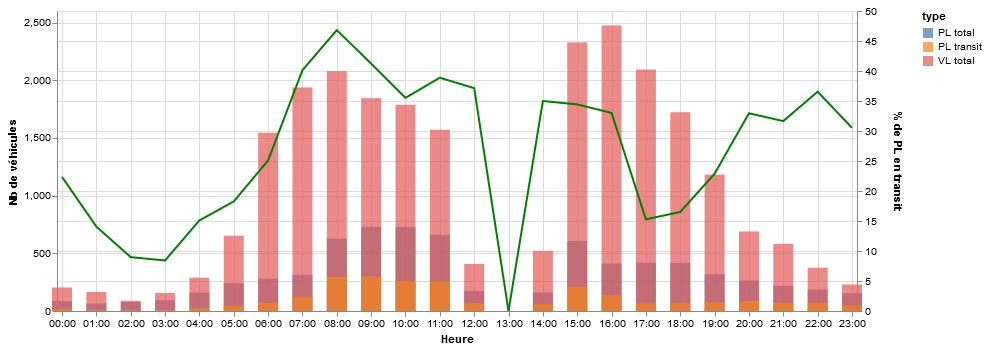

In [52]:
g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam, '2019-01-29', 4)

## 7.2 Redressement au niveau de la Rocade

In [59]:
# df des trajets concernes
df_trajet_rocade=pd.DataFrame(['N10-A63','N10-A660','N10-A62','A10-A63','A10-A660','A10-A62','A89-A63','A89-A660','A89-A62',
                                        'A63-N10','A63-A10','A63-A89','A62-N10','A62-A10','A62-A89','A660-N10','A660-A10','A660-A89'],
                                      columns=['trajets'])
df_trajet_rocade.to_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\liste_trajet_rocade.json', orient='index')

In [40]:
#rechercher ces trajets dans le dico des o_d
trajets_rocade=dico_od_final.loc[dico_od_final.o_d.isin(df_trajet_rocade.trajets.tolist())]
#trouver ceux qui ne contiennent aucune référence uax camera de la Rocade
trajets_rocade_non_vu=trajets_rocade.loc[trajets_rocade.apply(lambda x : all(e not in x['cameras'] for e in [1,2,3,4]),axis=1)].copy()

In [41]:
#créer des passage fictif au niveau de la Rocade avec comme created la moyenne entre date_cam_1 et date_cam_2
#et une camera fictive selon les ameras 1 et 2
def camera_fictive(cam1, cam2) : 
    if cam1 in [15,10,19] and cam2 in [5,11,7] : 
        return 4
    elif cam1 in [12,8,6] and cam2 in [13,9,18] :
        return 3
    else : 
        return -1
    
trajets_rocade_non_vu['created_fictif']=trajets_rocade_non_vu.apply(lambda x : x['date_cam_1']+((x['date_cam_2']-x['date_cam_1'])/2),axis=1)
trajets_rocade_non_vu['camera_fictif']=trajets_rocade_non_vu.apply(lambda x : camera_fictive(x['cameras'][0],x['cameras'][1]),axis=1)
trajets_rocade_non_vu=trajets_rocade_non_vu.drop(['date_cam_1', 'index','id', 'date_cam_2',
       'cameras', 'origine', 'destination', 'o_d', 'tps_parcours', 'period',
       'date', 'temps', 'type', 'tps_parcours_theoriq', 'filtre_tps'],axis=1)
trajets_rocade_non_vu.rename(columns={'created_fictif':'created','camera_fictif':'camera_id'},inplace=True)
#on ne garde que les trajets concernes par une des cameras fictive de la rocade
trajets_rocade_non_vu=trajets_rocade_non_vu.loc[trajets_rocade_non_vu['camera_id']!=-1]

In [49]:
#on ajoute les trajets ainsi cree aux autres (pl en transit et pl normaux)
df_passage_transit_redresse=pd.concat([trajets_rocade_non_vu,df_passages_transit],axis=0,sort=False)
df_pl_redresse=pd.concat([trajets_rocade_non_vu.set_index('created'),df_pl],axis=0,sort=False)
#attributs de tracage
df_passage_transit_redresse['fictif']=df_passage_transit_redresse.apply(lambda x : True if not x['fiability']>0 else False,axis=1)
df_passage_transit_redresse['fiability']=df_passage_transit_redresse.apply(lambda x : 999 if not x['fiability']>0 else x['fiability'],axis=1)
#caclcul et graph
%time synt_nb_veh_cam_redresse=t.pourcentage_pl_camera(df_pl_redresse,df_passage_transit_redresse, df_vl)

pl_tot =1920 , vl_tot=1920 , pl_transit=1262,pl_tot-joint-transit=1262
Wall time: 1.36 s


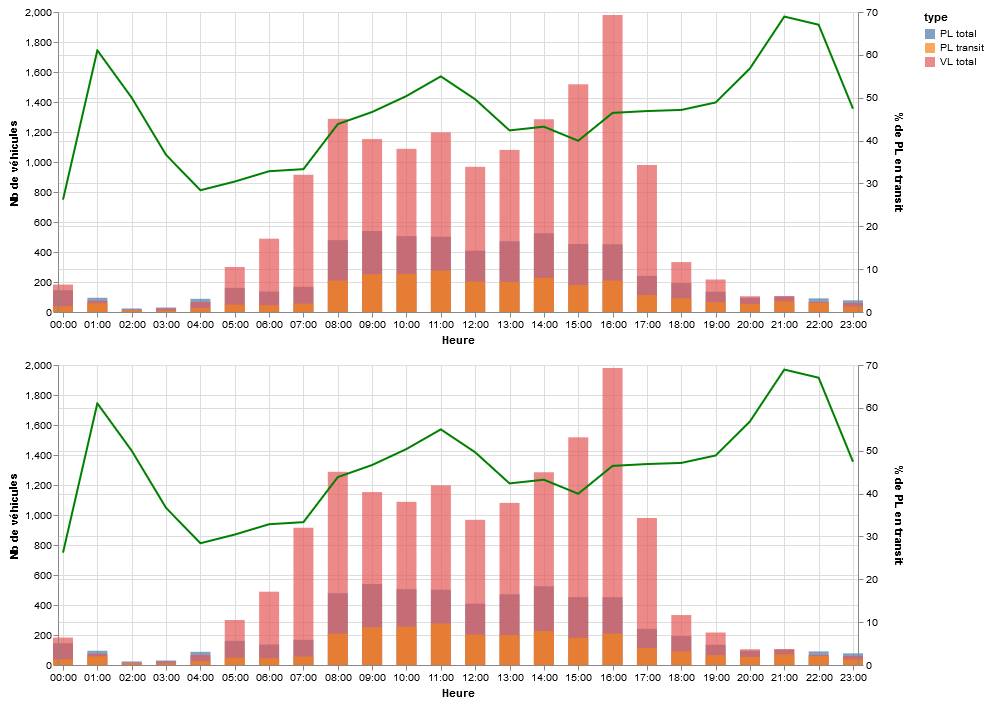

In [57]:
alt.vconcat(g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam, '2019-01-28', 5),g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam_redresse, '2019-01-28', 5))

## 7.3 Redressement des trajets extrapoles

In [ ]:
# de même que opur la rocade, il faut ajouter des passages fictifs à la df des passages afin de pouvoir approximer mieux les parts de PL
#trouver les passages extrapoles
# ajouter un attribut du type d'extrapolation : cam debut ou cam fin
#selon l'o_d crééer un passage fictuf avec le numero de la camera qui manque du trajets sensé avoir eu leiu
#estimer le temps de passage selon le temps theorique : date_cam_1 ou 2 +ou- temps ou temps theorique